### Research into existing image-stitching Pipeline

#### Typical Usage

Status: 0


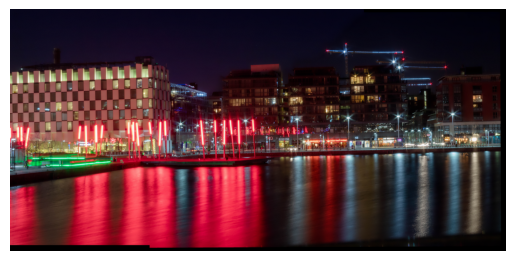

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgs = [cv2.imread(p) for p in (
    '../sample/sample3/GrandCanal_Pano-1.jpg',
    '../sample/sample3/GrandCanal_Pano-2.jpg'
)]

stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)
status, pano = stitcher.stitch(imgs)


print("Status:", status)

if status != cv2.Stitcher_OK:
    raise RuntimeError(f"Stitching failed with status {status}")


plt.imshow(cv2.cvtColor(pano, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### Pipeline Broken Down
#### Feature Detection (SIFT) 

**SIFT**: SIFT stands for Scale Invariant Feature Transform  
When stitching images you have to answer 'What pixel in Image A corresponds to what pixel in Image B?'  
But pixels change when the camera moves, or the image is zoomed, or lighting changes etc. SIFT solves this by finding stable, distinctive features.  

**Keypoints**: a key point is a special spot in an image that is easy to recognise again from another angle. if two images overlap, keypoints in the overlapping area should match.  
Some examples:
- corners of buildings
- window corners
- edges that intersect
- distinct dots or symbols
- unique texture patterns  

the following are not good examples because these areas look the same everywhere:
- sky
- flat walls
- water
- grass  

**Descriptors**: a discriptor is a vector of 128 numbers that describes the texture around a keypoint.
- keypoint: WHERE is this interesting thing?
- descriptor: WHAT does this interesting thing look like?  
Theyre needed because you cant match raw pixel data. noise, lighting, exposure all change. descriptors remain stable across:
- rotation
- scale changes
- lighting differences  




In [62]:
# scaled the images because otherwise it would take too long
scaled_imgs = [cv2.resize(img, None, fx=0.3, fy=0.3) for img in imgs]

# if it still takes really long uncomment this to limit it to 2000 keypoints
# sift = cv2.SIFT_create(nfeatures=2000)
sift = cv2.SIFT_create()

keypoints = []
descriptors = []
for img in scaled_imgs:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)


for i, kp in enumerate(keypoints):
    print(f"Image {i}: {len(kp)} keypoints")

Image 0: 5646 keypoints
Image 1: 5196 keypoints


#### Matching (BFMatcher)

Matching connects a keypoint from image A to a keypoint from image B is the descriptors are similar.  
It compares descriptor vectors using Euclidean distance:
- low distance -> similar = match
- high distance -> different = ignore

In [63]:
bf = cv2.BFMatcher()

# k=2 returns best and second-best match
raw_matches = bf.knnMatch(descriptors[0], descriptors[1], k=2)

# ratio test
good_matches = []
for m, n in raw_matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Total raw matches: {len(raw_matches)}")
print(f"Good matches after ratio test: {len(good_matches)}")

# some example distances
print("\nExamples of match distances:")
for i in range(5):
    print(f" Match {i}: dist={raw_matches[i][0].distance:.2f}, ",
          f"second-best={raw_matches[i][1].distance:.2f}")


Total raw matches: 5646
Good matches after ratio test: 1177

Examples of match distances:
 Match 0: dist=307.25,  second-best=312.16
 Match 1: dist=289.26,  second-best=312.15
 Match 2: dist=160.98,  second-best=177.10
 Match 3: dist=381.04,  second-best=385.06
 Match 4: dist=300.83,  second-best=314.12


#### Homography (RANSAC)

Homography is a 3x3 matrix that transforms image B into image A's coordinate system.  
This is where false matches are filtered out, geometric transformations are computed, and how it finds how image B must be 'warped' to align with image A.  

RANSAC (random sample consesnus)
- randomly picks 4 matches
- computes temporary homographies
- counts how many matches agree (inliers)
- picks the best one
- removes wrong matches (outliers)

In [64]:
# extract matched points
points_image1 = np.float32([keypoints[0][m.queryIdx].pt for m in good_matches])
points_image2 = np.float32([keypoints[1][m.trainIdx].pt for m in good_matches])

# get homography matrix H that maps image 2 to image 1
homography_matrix, inlier_mask = cv2.findHomography(points_image2, points_image1, cv2.RANSAC, 5.0)

# count inliers and outliers
inliers = np.sum(inlier_mask)
outliers = len(inlier_mask) - inliers
print(f"Inliers: {inliers}, Outliers: {outliers}")
print("homography matrix:\n", homography_matrix)

Inliers: 1114, Outliers: 63
homography matrix:
 [[ 9.02134910e-01 -4.57124428e-03  6.11820657e+02]
 [-3.33129882e-02  9.69624668e-01  2.83074886e+01]
 [-6.31130289e-05 -4.65217553e-06  1.00000000e+00]]


#### Warping

homography warps image B onto image A

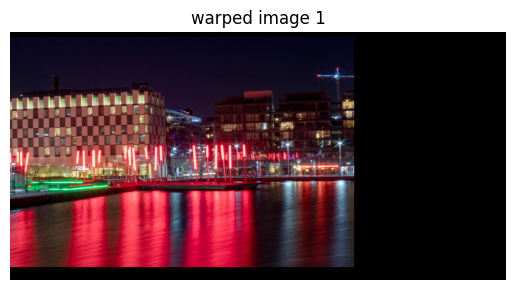

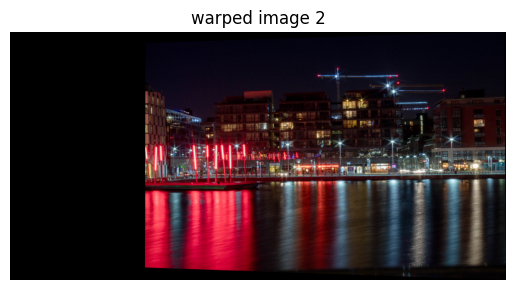

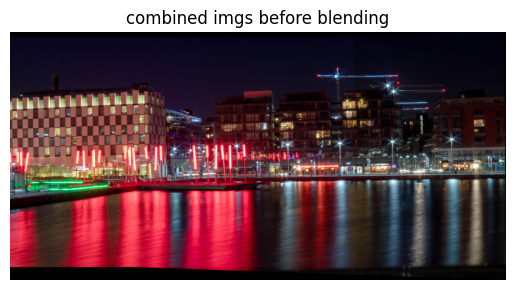

In [65]:
# compute canvas size
height_img1, width_img1 = scaled_imgs[0].shape[:2]
height_img2, width_img2 = scaled_imgs[1].shape[:2]

# corners of image 2
corners_img2 = np.float32([[0,0],[width_img2,0],[width_img2,height_img2],[0,height_img2]]).reshape(-1,1,2)
warped_corners_img2 = cv2.perspectiveTransform(corners_img2, homography_matrix)
corners_img1 = np.float32([[0,0],[width_img1,0],[width_img1,height_img1],[0,height_img1]]).reshape(-1,1,2)
all_corners = np.vstack((corners_img1, warped_corners_img2))

x_min, y_min = np.int32(all_corners.min(axis=0).ravel() - 0.5)
x_max, y_max = np.int32(all_corners.max(axis=0).ravel() + 0.5)

shift_x, shift_y = -x_min, -y_min
canvas_w, canvas_h = x_max - x_min, y_max - y_min
translation = np.array([[1,0,shift_x],[0,1,shift_y],[0,0,1]])

warped_img2 = cv2.warpPerspective(scaled_imgs[1], translation @ homography_matrix, (canvas_w, canvas_h))
warped_img1 = np.zeros((canvas_h, canvas_w, 3), np.uint8)
warped_img1[shift_y:shift_y+height_img1, shift_x:shift_x+width_img1] = scaled_imgs[0]

# display
plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("warped image 1")
plt.show()

plt.imshow(cv2.cvtColor(warped_img2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("warped image 2")
plt.show()

combined_preblend = np.maximum(warped_img1, warped_img2)
plt.imshow(cv2.cvtColor(combined_preblend, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("combined imgs before blending")
plt.show()


#### Multi-Band Blending

the image form before produced a harsh seam. this step makes it look natural.

multi-band blending
- preserves edges
- blends colours smoothly
- hides seams

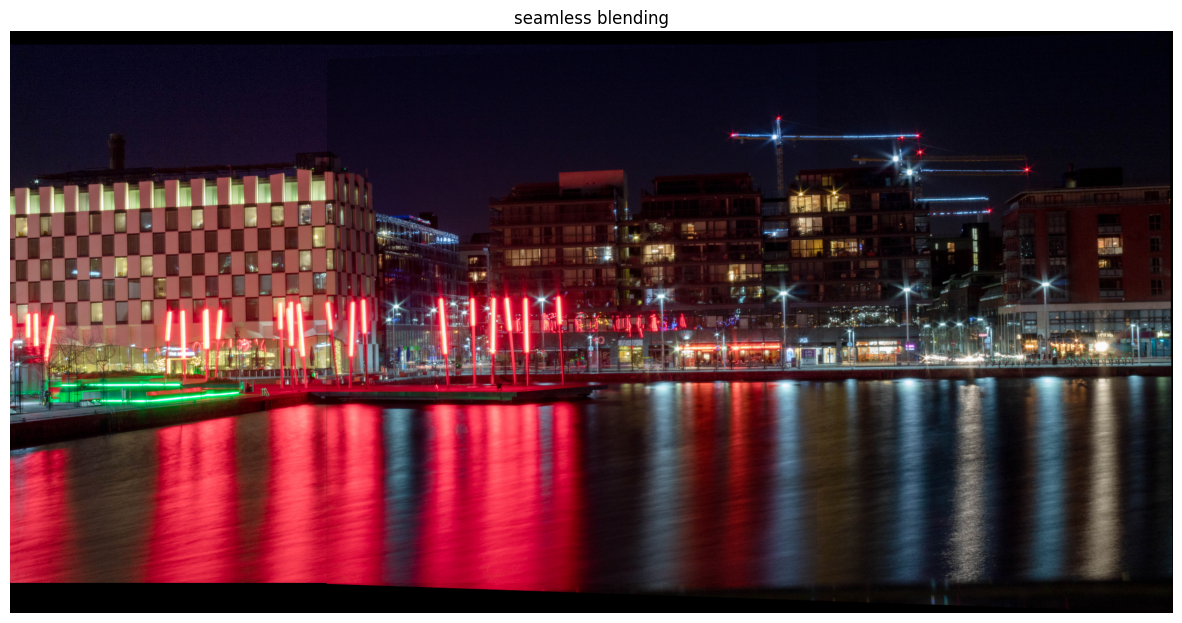

In [66]:
#warped_img1 and warped_img2 are the same canvas size
canvas_h, canvas_w = warped_img1.shape[:2]

# create a weight map for blending
# simple horizontal blending: left image fades out right image fades in
blend = np.zeros_like(warped_img1, dtype=np.float32)

# compute horizontal weights based on nonzero pixels
mask1 = (warped_img1 > 0).astype(np.float32)
mask2 = (warped_img2 > 0).astype(np.float32)

# compute sum of masks to normalize weights
weight_sum = mask1 + mask2
weight_sum[weight_sum == 0] = 1  # no division by zero

# weighted combination
blend = (warped_img1.astype(np.float32) * mask1 + warped_img2.astype(np.float32) * mask2) / weight_sum

# convert back to uint8
blend = np.clip(blend, 0, 255).astype(np.uint8)

# display
plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(blend, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("seamless blending")
plt.show()


### Weaknesses:

#### Feature Detection (SIFT):
- hard to find points in plain areas like sky or walls
- slow on big images
- struggles with very bright or dark spots

#### Feature Matching:
- false matches can survive ratio test
- repeating patterns confuse it
- some good matches might be ignored

#### Homography (RANSAC):
- assumes everything is flat, doesnt handle depth well
- can still include wrong matches
- fails with too few matches

#### Warping:
- can leave black edges or crop parts of images
- tiny misalignments can happen form rounding

#### Blending:
- if images are misaligned seams still visible
- wont fix big colour or brightness differences

#### Overall pipeline:
- ghosts or lines appear with depth differences
- lighting differences stay unless corrected
- mistakes in one step affect all others